# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

# Data Exploration

In [13]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [14]:
# read in the json files
portfolio = pd.read_json('Data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('Data/profile.json', orient='records', lines=True)
transcript = pd.read_json('Data/transcript.json', orient='records', lines=True)

### Exploring transcript

In [15]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [16]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [17]:
transcript.person.value_counts()

94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
79d9d4f86aca4bed9290350fb43817c2    48
                                    ..
afd41b230f924f9ca8f5ed6249616114     2
3a4e53046c544134bb1e7782248631d1     2
e63e42480aae4ede9f07cac49c8c3f78     2
7ecfc592171f4844bdc05bdbb48d3847     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: person, Length: 17000, dtype: int64

In [18]:
transcript.value.astype('str').value_counts().to_dict()

{"{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}": 14983,
 "{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}": 14924,
 "{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}": 14891,
 "{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}": 14835,
 "{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}": 14374,
 "{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}": 14305,
 "{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}": 11848,
 "{'offer id': '3f207df678b143eea3cee63160fa8bed'}": 11761,
 "{'offer id': '2906b810c7d4411798c6938adc9daaa5'}": 11750,
 "{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}": 10331,
 "{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}": 5317,
 "{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}": 5156,
 "{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}": 4354,
 "{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}": 4296,
 "{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}": 4017,
 "{'offer_id': 'ae264e3637204a6fb9bb56bc

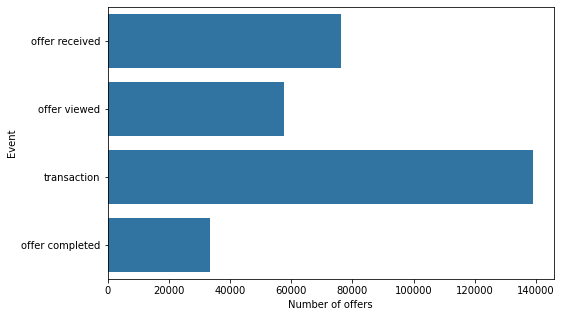

In [19]:
base_color = sb.color_palette()[0]
plt.rcParams['figure.figsize'] = 8, 5
sb.countplot(data =transcript , y='event', color = base_color)
plt.xlabel('Number of offers');
plt.ylabel('Event');

In [20]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


### Exploring profile

In [21]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [22]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [23]:
profile.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
101       5
99        5
Name: age, Length: 85, dtype: int64

In [24]:
profile.gender.isna().sum()

2175

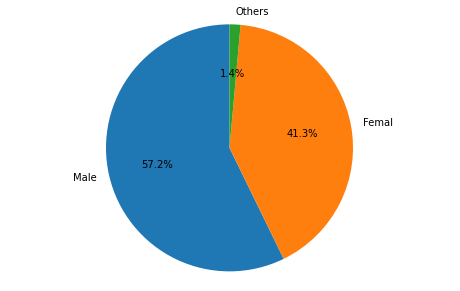

In [25]:
labels = 'Male', 'Femal', 'Others'
sizes = [15, 30, 45, 10]
fig1, ax1 = plt.subplots()
ax1.pie(profile.gender.value_counts(), labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Most of the users are male with no huge difference with female

Text(0.5, 0, 'Age')

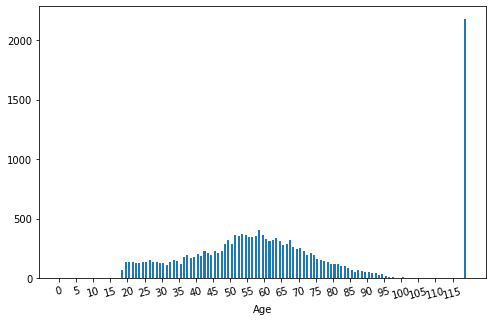

In [26]:
plt.rcParams['figure.figsize'] = 8, 5
bins = np.arange(0,120, 1)
ticks = np.arange(0, 120, 5)
plt.hist(data=profile, x='age', bins=bins, rwidth = 0.6);
plt.xticks(ticks, rotation = 15);
plt.xlabel('Age')

Her we se that most people are between 18 and 75 using the app while more use the app between 55 and 65. and the curve decreases 
tremendously after the age of 75.

In [27]:
profile.age.describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [28]:
profile[profile.age >= 95].isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

it looks like that When age is more than 95 the information of gender and income is not provided.

### Exploring portfolio

In [29]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [30]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [31]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [32]:
portfolio.reward.value_counts()

5     3
10    2
0     2
2     2
3     1
Name: reward, dtype: int64

In [33]:
portfolio.difficulty.value_counts()

10    4
0     2
5     2
20    1
7     1
Name: difficulty, dtype: int64

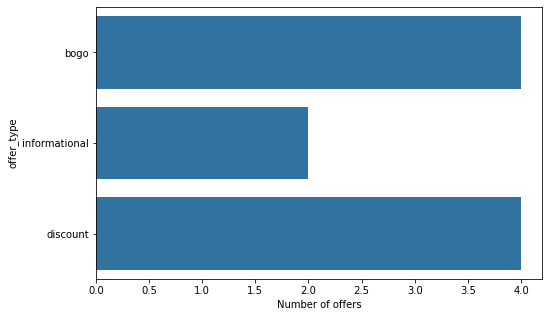

In [34]:
plt.rcParams['figure.figsize'] = 8, 5
sb.countplot(data =portfolio , y='offer_type', color = base_color)
plt.xlabel('Number of offers');
plt.ylabel('offer_type');

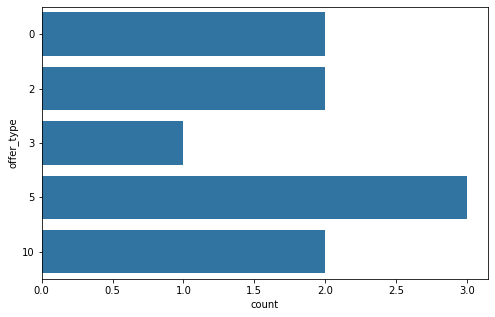

In [35]:
plt.rcParams['figure.figsize'] = 8, 5
sb.countplot(data =portfolio , y='reward', color = base_color)
plt.ylabel('offer_type');

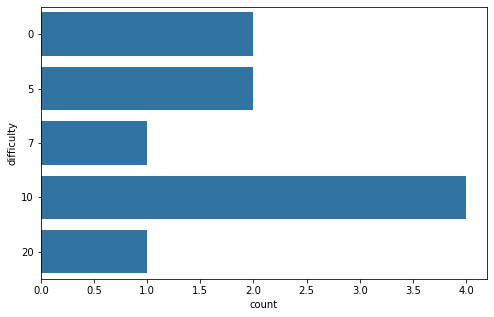

In [36]:
plt.rcParams['figure.figsize'] = 8, 5
sb.countplot(data =portfolio , y='difficulty', color = base_color)
plt.ylabel('difficulty');

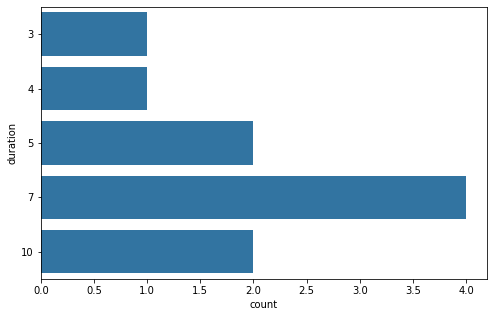

In [37]:
plt.rcParams['figure.figsize'] = 8, 5
sb.countplot(data =portfolio , y='duration', color = base_color)
plt.ylabel('duration');

Here we see that most duration for offers is 7 days and most offers used are bogo and discount equaly.

## Clean

### transcript
#### Define
- Change the name of person column into customer_id
- split the column dictionary based on its keys for ( offer_id, reward, amount)
- Drop the unnecessary columns

In [38]:
clean_trans = transcript.copy()

In [39]:
#Changing person column to customer_id
clean_trans = clean_trans.rename(columns = {'person':'customer_id'})

In [40]:
#Test
clean_trans.columns

Index(['customer_id', 'event', 'value', 'time'], dtype='object')

In [41]:
#spliting the dict into seperat columns
#starting with offer_id/offer id
clean_trans['offer_id'] = clean_trans.value.apply(lambda x: x.get('offer_id'))
clean_trans['offer id'] = clean_trans.value.apply(lambda x: x.get('offer id'))

In [42]:
#combining offer_id and offer id in one column offer_id
clean_trans['offer_id'] = clean_trans.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)

In [43]:
#we no longer need offer id so drop it
clean_trans.drop('offer id',axis = 1,inplace = True)

In [44]:
#Test
clean_trans.columns

Index(['customer_id', 'event', 'value', 'time', 'offer_id'], dtype='object')

In [45]:
#Now we split the rest of the dict reward and amount
clean_trans['offer_reward'] = clean_trans['value'].apply(lambda x: x.get('reward'))
clean_trans['amount'] = clean_trans['value'].apply(lambda x: x.get('amount'))

In [46]:
#we no longer need the value column
clean_trans.drop('value',axis = 1,inplace = True)

In [47]:
#fill all nan with 0
clean_trans.fillna(0 , inplace=True)

In [48]:
#Test
clean_trans.columns

Index(['customer_id', 'event', 'time', 'offer_id', 'offer_reward', 'amount'], dtype='object')

In [49]:
#Test
clean_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   customer_id   306534 non-null  object 
 1   event         306534 non-null  object 
 2   time          306534 non-null  int64  
 3   offer_id      306534 non-null  object 
 4   offer_reward  306534 non-null  float64
 5   amount        306534 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


### profile

#### Define
- rename id to customer_id
- change became_member_on datatype from string to datetime
- fill missing value in income with the mean
- fill missing value in income with the mode(most frequent)
- categorize peaple with there age


In [50]:
clean_prof=profile.copy()

In [51]:
#Changing id column to customer_id
clean_prof = clean_prof.rename(columns = {'id':'customer_id'})

In [52]:
#Test
clean_prof.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'income'], dtype='object')

In [53]:
#change became_member_on to datetime
clean_prof.became_member_on = pd.to_datetime(clean_prof['became_member_on'])

In [54]:
#Test
clean_prof.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   customer_id       17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


In [55]:
#fill missing value in income with the mean
clean_prof['income'] = clean_prof['income'].fillna(clean_prof['income'].mean())

In [56]:
#Test
clean_prof['income'].isnull().sum()

0

In [57]:
#fill missing value in income with the mode(most frequent)
mode = clean_prof['gender'].mode()[0]
clean_prof['gender'] = clean_prof['gender'].fillna(mode)

In [58]:
#Test
clean_prof.isnull().sum()

gender              0
age                 0
customer_id         0
became_member_on    0
income              0
dtype: int64

In [59]:
#Identify peaple older than 95 as outlaiers
clean_prof = clean_prof[clean_prof['age'] <=95]

In [60]:
#categorize peaple with there age
clean_prof['age_groups'] = pd.cut(clean_prof.age, bins=[0, 18, 30, 50, 70, 95], labels=['child', 'teen', 'young_adult', 'adult', 'old_man'])

In [61]:
clean_prof.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14777 entries, 1 to 16999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14777 non-null  object        
 1   age               14777 non-null  int64         
 2   customer_id       14777 non-null  object        
 3   became_member_on  14777 non-null  datetime64[ns]
 4   income            14777 non-null  float64       
 5   age_groups        14777 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 707.3+ KB


### portfolio

#### Define
- rename id to customer_id
- apply one hot encoding to channels column

In [62]:
clean_port = portfolio.copy()

In [63]:
clean_port = clean_port.rename(columns= {'id':'offer_id'})

In [64]:
#Test
clean_port.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type',
       'offer_id'],
      dtype='object')

In [65]:
# apply one hot encoding to channels column
clean_port['social'] = clean_port['channels'].apply(lambda x: 1 if 'social' in x else 0)
clean_port['web'] = clean_port['channels'].apply(lambda x: 1 if 'web' in x else 0)
clean_port['email'] = clean_port['channels'].apply(lambda x: 1 if 'email' in x else 0)
clean_port['mobile'] = clean_port['channels'].apply(lambda x: 1 if 'mobile' in x else 0)

In [66]:
clean_port.drop('channels',axis = 1,inplace = True)

In [67]:
clean_port.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   difficulty  10 non-null     int64 
 2   duration    10 non-null     int64 
 3   offer_type  10 non-null     object
 4   offer_id    10 non-null     object
 5   social      10 non-null     int64 
 6   web         10 non-null     int64 
 7   email       10 non-null     int64 
 8   mobile      10 non-null     int64 
dtypes: int64(7), object(2)
memory usage: 848.0+ bytes


In [68]:
clean_port.head()

,reward,difficulty,duration,offer_type,offer_id,social,web,email,mobile
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,0,1,1,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,1,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,1,0


**Last step in cleaning process merging all the datafremes.**

In [69]:
merge = pd.merge(clean_port, clean_trans, on='offer_id')
df = pd.merge(merge, clean_prof, on='customer_id')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148301 entries, 0 to 148300
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   reward            148301 non-null  int64         
 1   difficulty        148301 non-null  int64         
 2   duration          148301 non-null  int64         
 3   offer_type        148301 non-null  object        
 4   offer_id          148301 non-null  object        
 5   social            148301 non-null  int64         
 6   web               148301 non-null  int64         
 7   email             148301 non-null  int64         
 8   mobile            148301 non-null  int64         
 9   customer_id       148301 non-null  object        
 10  event             148301 non-null  object        
 11  time              148301 non-null  int64         
 12  offer_reward      148301 non-null  float64       
 13  amount            148301 non-null  float64       
 14  gend

In [71]:
df.head()

,reward,difficulty,duration,offer_type,offer_id,social,web,email,mobile,customer_id,event,time,offer_reward,amount,gender,age,became_member_on,income,age_groups
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,64,1970-01-01 00:00:00.020170909,100000.0,adult
1,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,64,1970-01-01 00:00:00.020170909,100000.0,adult
2,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,64,1970-01-01 00:00:00.020170909,100000.0,adult
3,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,64,1970-01-01 00:00:00.020170909,100000.0,adult
4,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,64,1970-01-01 00:00:00.020170909,100000.0,adult


## Data visualization

In [72]:
base_color = sb.color_palette()[0]

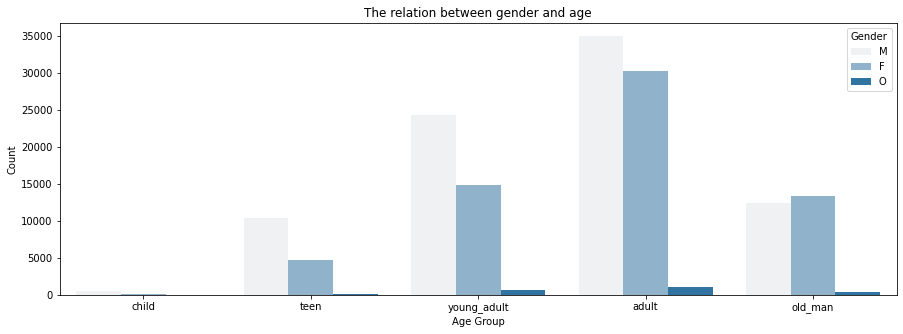

In [73]:
#Compare between age groups and genders
plt.rcParams['figure.figsize'] = 15, 5
sb.countplot(x= "age_groups", hue= "gender", data=df, color= base_color)
plt.title('The relation between gender and age')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

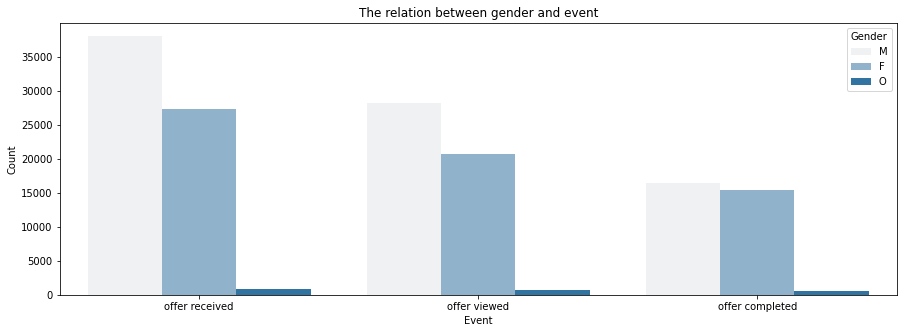

In [74]:
#compare between gender and events
sb.countplot(x= "event", hue= "gender", data=df,color= base_color)
plt.rcParams['figure.figsize'] = 15, 5
plt.title('The relation between gender and event')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Gender')

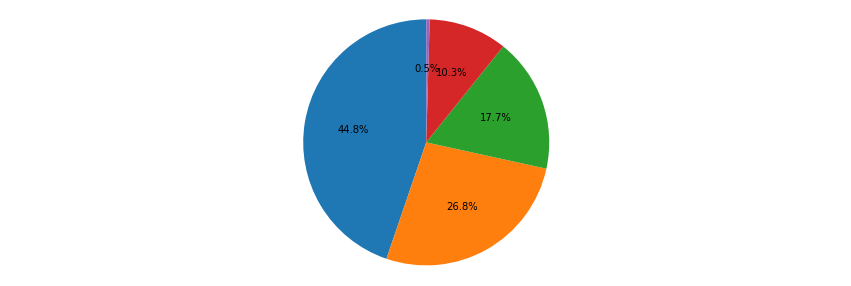

In [75]:
#What is the most resposive group of ages
fig1, ax1 = plt.subplots()
plt.rcParams['figure.figsize'] = 10 , 10

ax1.pie(df.age_groups.value_counts(), autopct='%1.1f%%',
         startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

**From Here we see that the most common gender is male and the most common age group is adults because of their work i suppose and the most common event is offer recieved.**

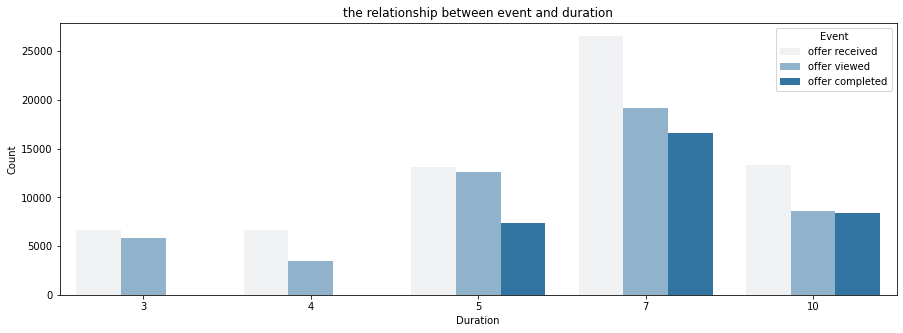

In [76]:
plt.rcParams['figure.figsize'] = 15, 5
sb.countplot(x= "duration", hue= "event", data=df,color= base_color)
plt.title('the relationship between event and duration')
plt.ylabel('Count')
plt.xlabel('Duration')
plt.legend(title='Event')

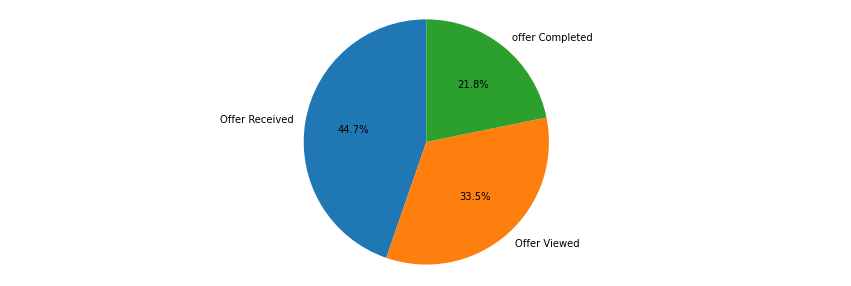

In [77]:
#The most popular event
labels = 'Offer Received', 'Offer Viewed', 'offer Completed'

fig1, ax1 = plt.subplots()
plt.rcParams['figure.figsize'] = 10 , 10
ax1.pie(df.event.value_counts(), labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

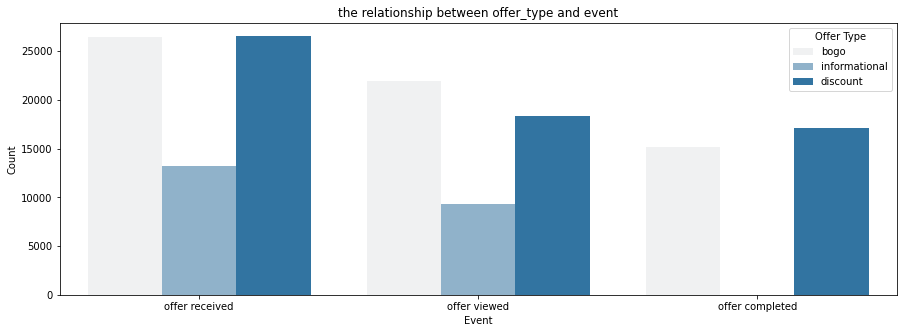

In [78]:
#Compare between event and offer_type
plt.rcParams['figure.figsize'] = 15, 5
sb.countplot(x= "event", hue= "offer_type", data=df,color= base_color)
plt.title('the relationship between offer_type and event')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')

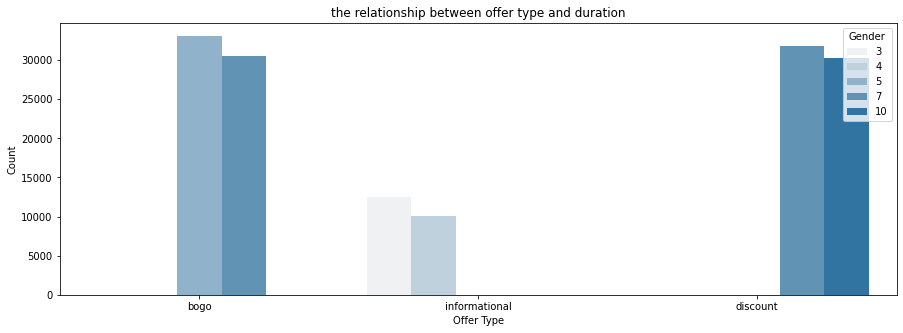

In [79]:
#Compare between offer_type and duration
plt.rcParams['figure.figsize'] = 15, 5
sb.countplot(x= "offer_type", hue= "duration", data=df,color= base_color)
plt.title('the relationship between offer type and duration')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

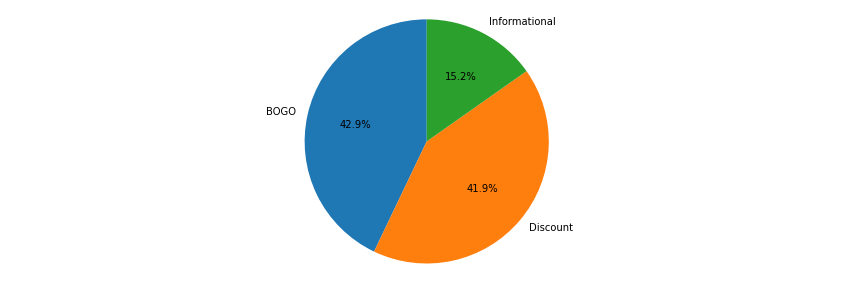

In [80]:
#The most popular offer type
labels = 'BOGO', 'Discount', 'Informational'

fig1, ax1 = plt.subplots()
plt.rcParams['figure.figsize'] = 10 , 10
ax1.pie(df.offer_type.value_counts(), labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

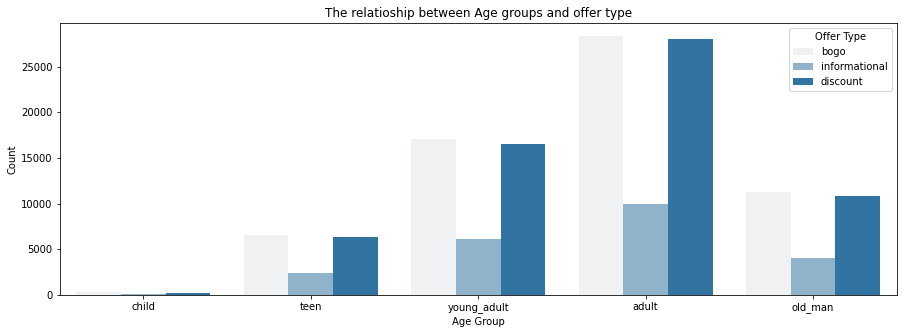

In [81]:
#Age groups and offer type
plt.rcParams['figure.figsize'] = 15, 5
sb.countplot(x= "age_groups", hue= "offer_type", data=df,color= base_color)
plt.title('The relatioship between Age groups and offer type')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Offer Type')

In [82]:
#Getting the mean of income
df['income'].mean()

66380.0783541581

C:\Users\omar_\miniconda3\envs\vision\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


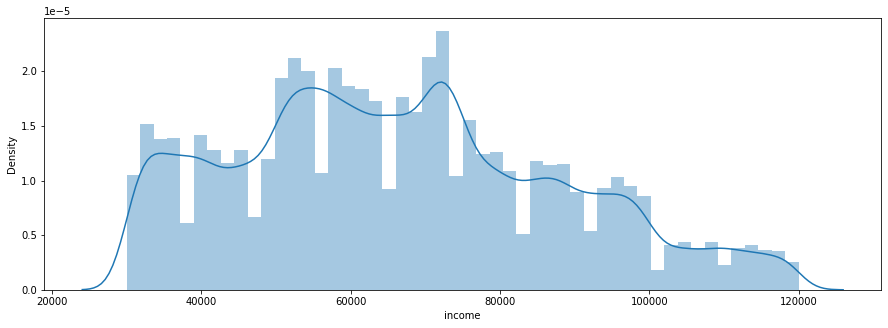

In [83]:
sb.distplot(df['income'], bins=50, hist_kws={'alpha': 0.4});

In [84]:
#Getting the mean age
df['age'].mean()

54.63133761741324

C:\Users\omar_\miniconda3\envs\vision\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


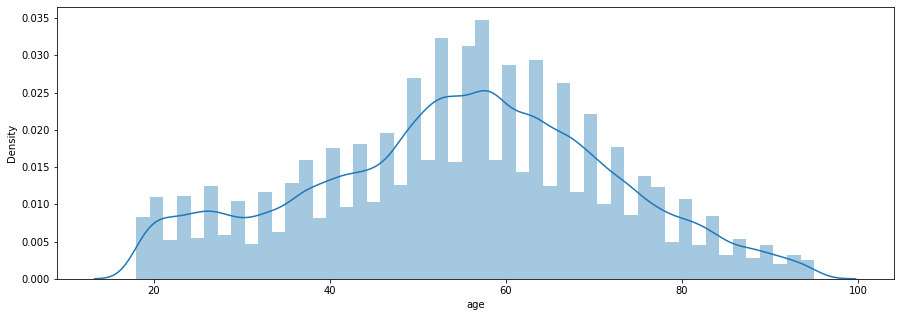

In [85]:
sb.distplot(df['age'], bins=50, hist_kws={'alpha': 0.4});

Most of the customer are between 45 and 65, Most peaple use BOGO and dicount offer type equaly. The number of people review the offer are much more than thos who comlete it.

## Data preperation

In [86]:
df_prep = df.copy()

In [87]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148301 entries, 0 to 148300
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   reward            148301 non-null  int64         
 1   difficulty        148301 non-null  int64         
 2   duration          148301 non-null  int64         
 3   offer_type        148301 non-null  object        
 4   offer_id          148301 non-null  object        
 5   social            148301 non-null  int64         
 6   web               148301 non-null  int64         
 7   email             148301 non-null  int64         
 8   mobile            148301 non-null  int64         
 9   customer_id       148301 non-null  object        
 10  event             148301 non-null  object        
 11  time              148301 non-null  int64         
 12  offer_reward      148301 non-null  float64       
 13  amount            148301 non-null  float64       
 14  gend

In [88]:
categorical = ['offer_type', 'gender', 'age_groups']
df_prep = pd.get_dummies(df_prep, columns = categorical)

In [89]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148301 entries, 0 to 148300
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   reward                    148301 non-null  int64         
 1   difficulty                148301 non-null  int64         
 2   duration                  148301 non-null  int64         
 3   offer_id                  148301 non-null  object        
 4   social                    148301 non-null  int64         
 5   web                       148301 non-null  int64         
 6   email                     148301 non-null  int64         
 7   mobile                    148301 non-null  int64         
 8   customer_id               148301 non-null  object        
 9   event                     148301 non-null  object        
 10  time                      148301 non-null  int64         
 11  offer_reward              148301 non-null  float64       
 12  am

In [90]:
from sklearn.preprocessing import MinMaxScaler


#change became_member_on column
df_prep['month_member'] = df_prep['became_member_on'].apply(lambda x: x.day)
df_prep['year_member'] = df_prep['became_member_on'].apply(lambda x: x.year)
#drop became_member_on column
df_prep.drop('became_member_on',axis=1, inplace=True)    
    
#process offer_id column
offer_id = df_prep['offer_id'].unique().tolist()
offer_mapping = dict( zip(offer_id,range(len(offer_id))) )
df_prep.replace({'offer_id': offer_mapping},inplace=True)

#process customer_id column
customer_id = df_prep['customer_id'].unique().tolist()
customer_mapping = dict( zip(customer_id,range(len(customer_id))) )
df_prep.replace({'customer_id': customer_mapping},inplace=True)
    
#process numerical variables
#initialize a MinMaxScaler and apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
number = ['income', 'difficulty', 'duration', 'offer_reward', 'time', 'reward', 'amount']
df_prep[number] = scaler.fit_transform(df_prep[number])
    
 #encode 'event' data to numerical values according to task 2
df_prep['event'] = df_prep['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})    

In [91]:
dset = df_prep.drop('event', axis=1)
labels = df_prep['event']

## Training and Testing

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [158]:
#Split the data into train test and validation
train_X, test_X, train_y, test_y = train_test_split(dset,labels, 
                                                        test_size=0.20,
                                                        stratify=labels, 
                                                        random_state=42)


In [159]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118640 entries, 21741 to 33383
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   reward                    118640 non-null  float64
 1   difficulty                118640 non-null  float64
 2   duration                  118640 non-null  float64
 3   offer_id                  118640 non-null  int64  
 4   social                    118640 non-null  int64  
 5   web                       118640 non-null  int64  
 6   mobile                    118640 non-null  int64  
 7   customer_id               118640 non-null  int64  
 8   time                      118640 non-null  float64
 9   offer_reward              118640 non-null  float64
 10  age                       118640 non-null  int64  
 11  income                    118640 non-null  float64
 12  offer_type_bogo           118640 non-null  uint8  
 13  offer_type_discount       118640 non-null

### Random Forest

In [132]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1500, stop = 6000, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
max_depth.append(None)
# Create the random grid
grid = {'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': ['auto', 'sqrt', 'log2']
       }

In [133]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(random_state = 42)

In [134]:
rf_Grid = GridSearchCV(estimator = rnd_clf, param_grid=grid,
                              cv=3, n_jobs = -1)

In [135]:
rf_Grid.fit(train_X, train_y)

C:\Users\omar_\miniconda3\envs\vision\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
62 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\omar_\miniconda3\envs\vision\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\omar_\miniconda3\envs\vision\lib\site-packages\sklearn\ensemble\_forest.py", line 442, in fit
    trees = Parallel(
  File "C:\Users\omar_\miniconda3\envs\vision\lib\site-packages\joblib\parallel.py", line 1046, in __call__
    while self.dispatch_one_batch(iterator)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 8, 12, 16, 20, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1500, 2625, 3750, 4875, 6000]})

In [137]:
rf_Grid.best_params_

{'max_depth': 16, 'max_features': 'auto', 'n_estimators': 1500}

In [140]:
rf_Grid.best_estimator_

RandomForestClassifier(max_depth=16, n_estimators=1500, random_state=42)

In [145]:
cvres = rf_Grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.7124494352511409 {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 1500}
0.7124494352511409 {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 2625}
0.7124494352511409 {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 3750}
0.7124494352511409 {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 4875}
0.7124494352511409 {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 6000}
0.7124494352511409 {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 1500}
0.7124494352511409 {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 2625}
0.7124494352511409 {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 3750}
0.7124494352511409 {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 4875}
0.7124494352511409 {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 6000}
0.7124494352511409 {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 1500}
0.7124494352511409 {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 2625}
0.71244943525114

In [148]:
Classifier = RandomForestClassifier(max_depth= 16, max_features= 'auto', n_estimators= 1500, oob_score=True, bootstrap= True)
Classifier.fit(train_X, train_y)

C:\Users\omar_\miniconda3\envs\vision\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(max_depth=16, n_estimators=1500, oob_score=True)

In [152]:
for name, score in zip(dset.columns, Classifier.feature_importances_):
    print(name, score)

reward 0.007741490453818288
difficulty 0.009285216740007504
duration 0.008234371903291009
offer_id 0.004791842382152296
social 0.010748213715834818
web 0.0016402924085629263
email 0.0
mobile 0.0024419702703028065
customer_id 0.03278793400968198
time 0.22453794990736303
offer_reward 0.6369320031578218
amount 0.0
age 0.01918111110222547
income 0.02689610029705491
offer_type_bogo 0.0009164158967084022
offer_type_discount 0.0012925168132913998
offer_type_informational 0.005599109183163412
gender_F 0.001356775088528086
gender_M 0.0014130812589099272
gender_O 0.0006654009963040614
age_groups_child 0.000234751652225857
age_groups_teen 0.000975457438756148
age_groups_young_adult 0.0008431679944944898
age_groups_adult 0.0008219189245217373
age_groups_old_man 0.0006629084049796758
month_member 0.0
year_member 0.0


In [156]:
dset = dset.drop(labels=['year_member', 'month_member','age_groups_old_man', 'age_groups_adult', 'age_groups_young_adult','age_groups_teen','age_groups_child','gender_O','amount','email'], axis=1)

In [160]:
Classifier = RandomForestClassifier(max_depth= 16, max_features= 'auto', n_estimators= 1500, oob_score=True, bootstrap= True)
Classifier.fit(train_X, train_y)

C:\Users\omar_\miniconda3\envs\vision\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(max_depth=16, n_estimators=1500, oob_score=True)

In [163]:
Classifier.oob_score_

0.844462238705327

In [164]:
y_pred = Classifier.predict(test_X)

In [165]:
accuracy_score(test_y,y_pred)

0.8472404841374195

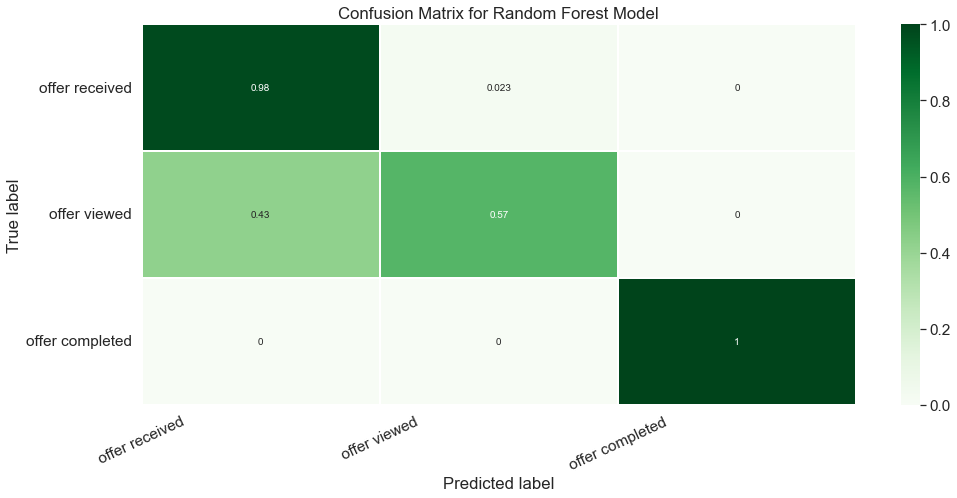

In [176]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(test_y, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sb.set(font_scale=1.4)
sb.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['offer received', 'offer viewed', 'offer completed']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()
